In [ ]:
# Importer les bibliothèques essentielles
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
import xgboost as xgb
!pip install --upgrade scikit-learn==1.2.2 xgboost==1.7.6



In [ ]:
# Monter Google Drive pour accéder aux fichiers sauvegardés
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Définir les chemins des fichiers dans Google Drive
base_drive_dir = '/content/drive/MyDrive/projet/'

# Dossiers de monitoring et training
monitoring_dir = os.path.join(base_drive_dir, 'monitoring')
training_dir = os.path.join(base_drive_dir, 'training')

# Chemins des fichiers de données et des artefacts
ref_data_path = os.path.join(monitoring_dir, 'ref_data.csv')
test_data_path = os.path.join(monitoring_dir, 'test_data.csv')
scaler_path = os.path.join(training_dir, 'scaler.pkl')
pca_path = os.path.join(training_dir, 'pca.pkl')

# Chemin de sauvegarde du modèle
model_save_path = os.path.join(training_dir, 'model_xgb.pkl')


In [ ]:
# Charger les données d'entraînement et de validation
df_ref = pd.read_csv(ref_data_path)
print(f"Shape de ref_data.csv : {df_ref.shape}")

# Charger les données de test
df_test = pd.read_csv(test_data_path)
print(f"Shape de test_data.csv : {df_test.shape}")


Shape de ref_data.csv : (87000, 101)
Shape de test_data.csv : (28, 101)


In [ ]:
# Charger le scaler
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# Charger le PCA
with open(pca_path, 'rb') as f:
    pca = pickle.load(f)

print("Scaler et PCA chargés avec succès.")


Scaler et PCA chargés avec succès.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.6.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Séparer les caractéristiques et les étiquettes
X = df_ref.drop('label', axis=1).values
y = df_ref['label'].values

# Si vous avez déjà appliqué le scaler et le PCA lors de la transformation, X est déjà prêt.
# Sinon, vous devez appliquer scaler et PCA ici :
# X_scaled = scaler.transform(X)
# X_pca = pca.transform(X_scaled)

# Pour cet exemple, supposons que X est déjà transformé (après scaler et PCA)
X_pca = X  # Si ce n'est pas le cas, décommentez les lignes ci-dessus

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape de X_train : {X_train.shape}")
print(f"Shape de X_val : {X_val.shape}")
print(f"Shape de y_train : {y_train.shape}")
print(f"Shape de y_val : {y_val.shape}")


Shape de X_train : (69600, 100)
Shape de X_val : (17400, 100)
Shape de y_train : (69600,)
Shape de y_val : (17400,)


In [ ]:
# Définir les paramètres pour XGBoost avec support GPU
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y)),
    'tree_method': 'hist',  # Nouveau paramètre
    'device': 'cuda',       # Spécifie l'utilisation du GPU
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'random_state': 42
}


# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(**xgb_params)

# Entraîner le modèle
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

print("Modèle XGBoost entraîné avec succès.")


[16:54:00] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[0]	validation_0-mlogloss:2.88151
[1]	validation_0-mlogloss:2.61265
[2]	validation_0-mlogloss:2.41371
[3]	validation_0-mlogloss:2.25349
[4]	validation_0-mlogloss:2.11807
[5]	validation_0-mlogloss:2.00138
[6]	validation_0-mlogloss:1.89736
[7]	validation_0-mlogloss:1.80564
[8]	validation_0-mlogloss:1.72252
[9]	validation_0-mlogloss:1.64688
[10]	validation_0-mlogloss:1.57637
[11]	validation_0-mlogloss:1.51168
[12]	validation_0-mlogloss:1.45112
[13]	validation_0-mlogloss:1.39659
[14]	validation_0-mlogloss:1.34533
[15]	validation_0-mlogloss:1.29719
[16]	validation_0-mlogloss:1.25125
[17]	validation_0-mlogloss:1.20768
[18]	validation_0-mlogloss:1.16666
[19]	validation_0-mlogloss:1.12842
[20]	validation_0-mlogloss:1.09222
[21]	validation_0-mlogloss:1.05821
[22]	validation_0-mlogloss:1.02689
[23]	validation_0-mlogloss:0.99629
[24]	validation_0-mlogloss:0.96755
[25]	validation_0-mlogloss:0.93982
[26]	validation_

Précision sur l'ensemble de validation : 95.23%
Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       600
           1       0.95      0.96      0.96       600
           2       0.99      0.98      0.99       600
           3       0.98      0.98      0.98       600
           4       0.93      0.93      0.93       600
           5       0.98      0.99      0.98       600
           6       0.97      0.96      0.96       600
           7       0.97      0.97      0.97       600
           8       0.93      0.94      0.94       600
           9       0.98      0.96      0.97       600
          10       0.96      0.95      0.95       600
          11       0.97      0.98      0.98       600
          12       0.96      0.94      0.95       600
          13       0.96      0.95      0.96       600
          14       0.95      0.97      0.96       600
          15       0.98      0.97      0.97       600
     

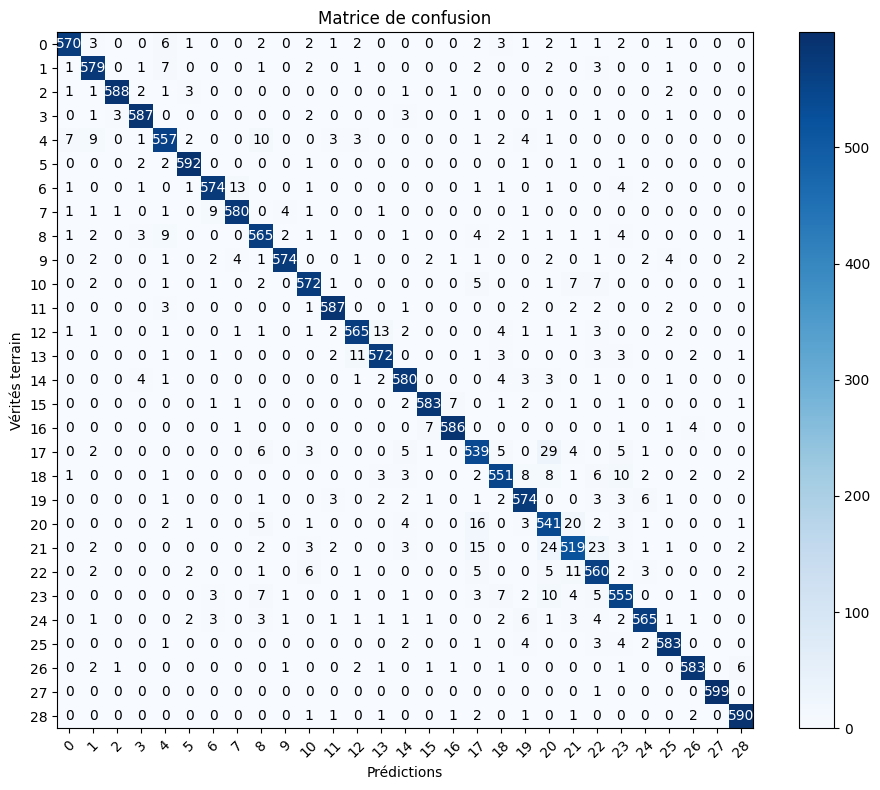

In [ ]:
# Prédictions sur l'ensemble de validation
y_val_pred = model.predict(X_val)

# Calculer la précision
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Précision sur l'ensemble de validation : {accuracy * 100:.2f}%")

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_val, y_val_pred))

# Afficher la matrice de confusion
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_val, y_val_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
classes = sorted(np.unique(y))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')

# Ajouter les valeurs dans la matrice
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [ ]:
# Sauvegarder le modèle entraîné dans le dossier training
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Modèle XGBoost sauvegardé dans {model_save_path}")


Modèle XGBoost sauvegardé dans /content/drive/MyDrive/projet/training/model_xgb.pkl


In [ ]:
# Sauvegarder les performances du modèle dans un fichier texte
performance_path = os.path.join(training_dir, 'performance_xgb.txt')

with open(performance_path, 'w') as f:
    f.write(f"Précision sur l'ensemble de validation : {accuracy * 100:.2f}%\n")
    f.write("Rapport de classification :\n")
    f.write(classification_report(y_val, y_val_pred))
    f.write("\nMatrice de confusion :\n")
    f.write(np.array2string(confusion_matrix(y_val, y_val_pred)))

print(f"Performances sauvegardées dans {performance_path}")


Performances sauvegardées dans /content/drive/MyDrive/projet/training/performance_xgb.txt


In [ ]:
import shutil

# Définir les chemins des fichiers générés
model_src = model_save_path  # '/content/drive/MyDrive/projet/training/model_xgb.pkl'
performance_src = performance_path  # '/content/drive/MyDrive/projet/training/performance_xgb.txt'

# Définir les dossiers de destination
# Par exemple, sauvegarder le modèle dans 'training/models' et les performances dans 'training/reports'
models_dir = os.path.join(training_dir, 'models')
reports_dir = os.path.join(training_dir, 'reports')

# Créer les dossiers s'ils n'existent pas
os.makedirs(models_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

# Définir les chemins de destination
model_dst = os.path.join(models_dir, 'model_xgb.pkl')
performance_dst = os.path.join(reports_dir, 'performance_xgb.txt')

# Copier les fichiers dans les dossiers de destination
shutil.copy(model_src, model_dst)
shutil.copy(performance_src, performance_dst)

print("Fichiers sauvegardés dans les dossiers 'models' et 'reports' sur Google Drive.")


Fichiers sauvegardés dans les dossiers 'models' et 'reports' sur Google Drive.


In [ ]:
from sklearn.model_selection import cross_val_score

# Validation croisée à 5 plis
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Précision moyenne : {cv_scores.mean() * 100:.2f}%")


[17:23:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:23:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:24:31] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:25:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:25:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

Scores de validation croisée : [0.9496408  0.94920977 0.94389368 0.94971264 0.94942529]
Précision moyenne : 94.84%


In [ ]:
# Sauvegarder les résultats de validation croisée dans un fichier texte
cv_results_path = os.path.join(training_dir, 'reports', 'cv_results.txt')

# Créer le dossier s'il n'existe pas
os.makedirs(os.path.dirname(cv_results_path), exist_ok=True)

with open(cv_results_path, 'w') as f:
    f.write("Scores de validation croisée :\n")
    f.write(", ".join([f"{score:.4f}" for score in cv_scores]) + "\n")
    f.write(f"Précision moyenne : {cv_scores.mean() * 100:.2f}%\n")

print(f"Résultats de validation croisée sauvegardés dans {cv_results_path}")


Résultats de validation croisée sauvegardés dans /content/drive/MyDrive/projet/training/reports/cv_results.txt
